## effect size sharing for multi-gene qtls

say we have a qtl that impacts multiple genes. How does the fractional effect of that qtl on each gene vary? w.r.t for instance distance from qtl to tss? maybe tie in ABC connections here? Maybe build a model that predicts how qtl impact on each gene will be split based on gene baseline expression, distance, ect

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from ast import literal_eval
import re
import scipy as sp
from scipy.stats import linregress
import statsmodels.api as sm


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

import upsetplot as up
#from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
from tqdm.auto import tqdm 
tqdm.pandas()

In [5]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)


### load in data
* effect sizes for qtls
* overlap dfs
* gencode for tss starts

take the subset of varaints in pcqtl determined credible sets, and calculate the varience-explained on a per gene basis for each gene in the cluster and for the cluster-pc overall

variance for each egene-cluster-credibleset(pc and cs num)

In [6]:
# takes about 30 seconds
susie_annotated = load_across_tissues(config, load_susie_annotated, tissue_ids = tissue_ids)

In [8]:
# some did not annotate properly, not sure why? just remove for now
print(len(susie_annotated))
susie_annotated = susie_annotated[~(susie_annotated['egene_id_list'] == '[nan]')]
print(len(susie_annotated))

899228
892013


/local/scratch/klawren/slrmtmp.47304989/ipykernel_34496/1199931872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pcsusie_annotated['egene_qtl_slope_flipped'] = pcsusie_annotated['egene_qtl_slope_flipped'].apply(literal_eval)


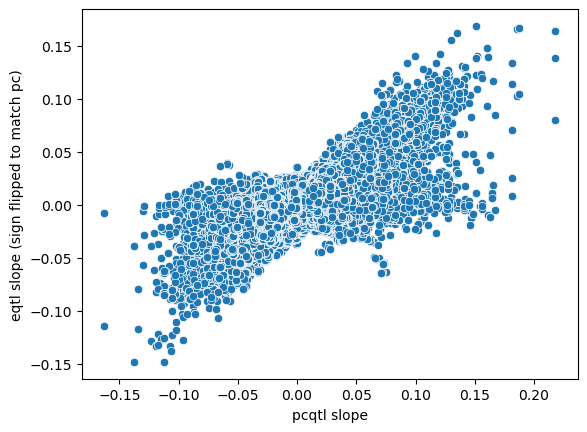

In [9]:
# look at pcqtl slope vs eqtl slope (per variant)
pcsusie_annotated = susie_annotated[susie_annotated['phenotype_id'].str.contains('_pc')]
pcsusie_annotated['egene_qtl_slope_flipped'] = pcsusie_annotated['egene_qtl_slope_flipped'].apply(literal_eval)
ax = sns.scatterplot(data = pcsusie_annotated[['phenotype_id', 'qtl_slope', 'egene_qtl_slope_flipped']].explode(['egene_qtl_slope_flipped']),
             x='qtl_slope',
             y='egene_qtl_slope_flipped')
ax.set_xlabel('pcqtl slope')
ax.set_ylabel('eqtl slope (sign flipped to match pc)')
plt.show()

In [10]:
# pip weight the slope 
susie_annotated['pip_weighted_slope'] = susie_annotated['pip'] * susie_annotated['qtl_slope']
susie_annotated['pip_weighted_af'] = susie_annotated['pip'] * susie_annotated['af']


# group by credible sets
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'pip_weighted_slope':sum,
                                                                                  'pip_weighted_af':sum}).reset_index()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
    # split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'

# flip the slope for major alleles
#cs_grouped['pip_weighted_slope'] = np.where(cs_grouped['pip_weighted_af'] > .5, -cs_grouped['pip_weighted_slope'], cs_grouped['pip_weighted_slope'])


<AxesSubplot: xlabel='pip_weighted_slope', ylabel='Count'>

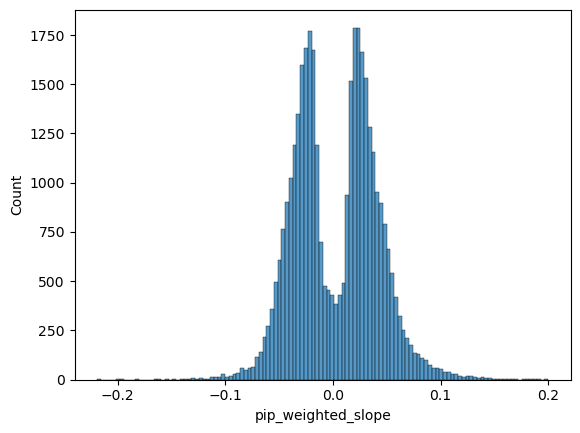

In [11]:
sns.histplot(cs_grouped, x='pip_weighted_slope')

In [ ]:
# merge on signal sets 
underlying_signals = load_across_tissues(config, load_signal_groups)


In [23]:
underlying_signals['exclusive_label'] = np.where((underlying_signals['num_e_coloc'] > 0), np.where((underlying_signals['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

In [19]:
# weight the eqene_qtl_slope by the pcqtl credible set pip
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].apply(literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].apply(literal_eval)

# expand out over all egenes for a given pcqtl
susie_annotated_egene_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_id_list'])

# weight by pip
susie_annotated_egene_explode['pip_weighted_eqtl_slope'] = susie_annotated_egene_explode['egene_qtl_slope']*susie_annotated_egene_explode['pip']

# group by credible sets and egene
cs_grouped_eqtl_mapped = susie_annotated_egene_explode.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'egene_id_list']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'pip_weighted_slope':sum, 
                                                                                  'pip_weighted_eqtl_slope':sum}).reset_index()

In [21]:
# look just at pairs
cs_grouped_eqtl_mapped_pairs = cs_grouped_eqtl_mapped[cs_grouped_eqtl_mapped['cluster_id'].str.split('_').apply(len) < 3]

In [ ]:
# group over egenes in a credible set
cs_grouped_eqtl_mapped_pairs = cs_grouped_eqtl_mapped_pairs.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'egene_id_list':list,
                                                                                  'pip_weighted_eqtl_slope':list, 
                                                                                  'pip_weighted_slope':'first'}).reset_index()



In [66]:
gid_gencode, full_gencode = load_gencode()

def get_egene_distances(cs):
    return list(gid_gencode.loc[cs['egene_id_list']]['tss_start'] - cs['lead_var_position'])

cs_grouped_eqtl_mapped_pairs['egene_distances'] = cs_grouped_eqtl_mapped_pairs.progress_apply(get_egene_distances, axis=1)

  0%|          | 0/30239 [00:00<?, ?it/s]

In [ ]:
# make it so gene a is always the closer one
first_gene_closer = cs_grouped_eqtl_mapped_pairs['egene_distances'].str[0].abs()<cs_grouped_eqtl_mapped_pairs['egene_distances'].str[1].abs()
cs_grouped_eqtl_mapped_pairs['slope_gene_a'] = np.where(first_gene_closer, cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[0], cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[1])
cs_grouped_eqtl_mapped_pairs['slope_gene_b'] = np.where(first_gene_closer, cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[1], cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[0])
cs_grouped_eqtl_mapped_pairs['distance_gene_a'] = np.where(first_gene_closer, cs_grouped_eqtl_mapped_pairs['egene_distances'].str[0], cs_grouped_eqtl_mapped_pairs['egene_distances'].str[1])
cs_grouped_eqtl_mapped_pairs['distance_gene_b'] = np.where(first_gene_closer, cs_grouped_eqtl_mapped_pairs['egene_distances'].str[1], cs_grouped_eqtl_mapped_pairs['egene_distances'].str[0])

In [97]:
# merge into coloc signal groups
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
underlying_signals_explode = pd.merge(underlying_signals.explode('cs_id'), cs_grouped_eqtl_mapped_pairs[['cs_id', 'tissue_id', 'slope_gene_a', 'slope_gene_b', 'distance_gene_a', 'distance_gene_b']], on=['cs_id', 'tissue_id'], how='inner')
underlying_signals_annotated = underlying_signals_explode.groupby(['signal_id', 'tissue_id']).agg({'slope_gene_a':'mean', 'slope_gene_b':'mean', 'num_e_coloc':'first', 'num_pc_coloc':'first', 'exclusive_label':'first', 'cluster_id':'first', 'distance_gene_a':'first', 'distance_gene_b':'first'})

# make the sign relative to the slope a
# TODO should the be so minor is always one sign?
underlying_signals_annotated['sign_flipped_slope_gene_b'] = np.where(underlying_signals_annotated['slope_gene_a'] < 0, - underlying_signals_annotated['slope_gene_b'], underlying_signals_annotated['slope_gene_b'])
underlying_signals_annotated['sign_flipped_slope_gene_a'] = np.where(underlying_signals_annotated['slope_gene_a'] < 0, - underlying_signals_annotated['slope_gene_a'], underlying_signals_annotated['slope_gene_a'])

In [79]:
clusters = load_across_tissues(config, load_clusters_annotated)
# add cluster info
underlying_signals_annotated = pd.merge(underlying_signals_annotated, clusters, on=['cluster_id', 'tissue_id'], how='left')

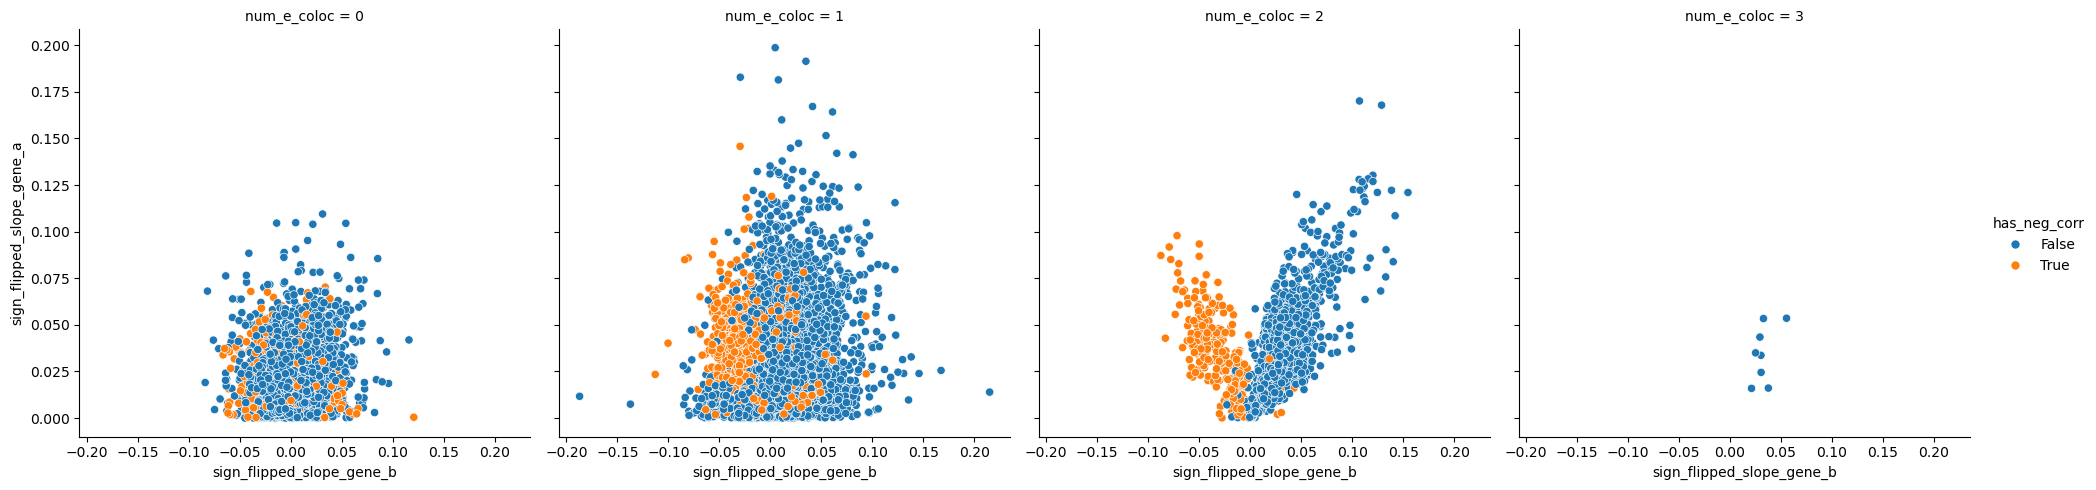

In [87]:
sns.relplot(underlying_signals_annotated, y='sign_flipped_slope_gene_a', x='sign_flipped_slope_gene_b', col='num_e_coloc', hue='has_neg_corr', kind='scatter')

In [99]:
# look for annotation enrichments in theta and r
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x) 
    return r, theta

# Apply the function to the DataFrame
underlying_signals_annotated['eqtl_effect_r'], underlying_signals_annotated['eqtl_effect_theta'] = zip(*underlying_signals_annotated.progress_apply(lambda row: cartesian_to_polar(row['sign_flipped_slope_gene_a'], row['sign_flipped_slope_gene_b']), axis=1))


  0%|          | 0/16971 [00:00<?, ?it/s]

In [100]:
underlying_signals_annotated

slope_gene_a  \
signal_id                                          tissue_id                            
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Lung                     -0.004132   
                                                   Nerve_Tibial             -0.023788   
                                                   Thyroid                   0.001146   
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Artery_Tibial            -0.023793   
                                                   Esophagus_Muscularis     -0.030144   
...                                                                               ...   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Esophagus_Mucosa         -0.005164   
                                                   Esophagus_Muscularis     -0.035505   
                                                   Whole_Blood              -0.004911   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Adipose_Subcutaneous     -0.028143   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Adipose_Subcutaneous     -0.024411   

                                                                         slope_gene_b  \
signal_id                                          tissue_id                            
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Lung                     -0.010441   
                                                   Nerve_Tibial             -0.032301   
                                                   Thyroid                   0.004342   
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Artery_Tibial            -0.018521   
                                                   Esophagus_Muscularis     -0.025209   
...                                                                               ...   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Esophagus_Mucosa          0.013288   
                                                   Esophagus_Muscularis      0.027388   
                                                   Whole_Blood               0.008976   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Adipose_Subcutaneous      0.030364   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Adipose_Subcutaneous      0.030459   

                                                                         num_e_coloc  \
signal_id                                          tissue_id                           
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Lung                            1   
                                                   Nerve_Tibial                    1   
                                                   Thyroid                         1   
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Artery_Tibial                   2   
                                                   Esophagus_Muscularis            2   
...                                                                              ...   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Esophagus_Mucosa                2   
                                                   Esophagus_Muscularis            2   
                                                   Whole_Blood                     2   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Adipose_Subcutaneous            1   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... Adipose_Subcutaneous            1   

                                                                         num_pc_coloc  \
signal_id                                          tissue_id                            
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Lung                             0   
                                                   Nerve_Tibial                     0   
                                                   Thyroid                          0   
ENSG00000000971.15_ENSG00000162687.16_e_ENSG000... Artery_Tibial                    1   
                                                   Esophagus_Muscularis       

<AxesSubplot: ylabel='Count'>

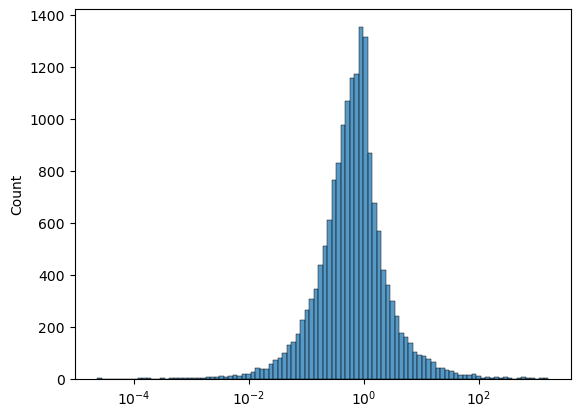

In [114]:
sns.histplot(underlying_signals_annotated['sign_flipped_slope_gene_b'].abs()/underlying_signals_annotated['sign_flipped_slope_gene_a'].abs(), bins=100, log_scale=True)

<AxesSubplot: xlabel='None', ylabel='None'>

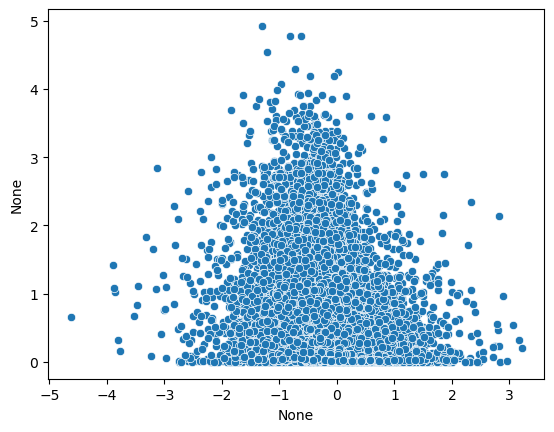

In [ ]:
ax = sns.scatterplot(x=np.log10(underlying_signals_annotated['sign_flipped_slope_gene_b'].abs()/underlying_signals_annotated['sign_flipped_slope_gene_a'].abs()), 
                y=np.log10(underlying_signals_annotated['distance_gene_b'].abs()/underlying_signals_annotated['distance_gene_a'].abs()))

ax.set_xlabel('Ratio of gene B')

In [122]:
underlying_signals_annotated['dist_ratio'] = underlying_signals_annotated['distance_gene_b'].abs()/(underlying_signals_annotated['distance_gene_a'].abs()+1)

In [123]:
underlying_signals_annotated['distance_gene_a'].abs().min()

0

In [124]:
x = underlying_signals_annotated[['sign_flipped_slope_gene_a', 'dist_ratio']].abs().astype(float)
y = underlying_signals_annotated['sign_flipped_slope_gene_b'].abs().values.astype(float)
x_with_constant = sm.add_constant(x) 
model = sm.OLS(y, x_with_constant)

result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     747.7
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          6.51e-312
Time:                        13:38:16   Log-Likelihood:                 45370.
No. Observations:               16971   AIC:                        -9.073e+04
Df Residuals:                   16968   BIC:                        -9.071e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# lead var grouped

## multigene qtls

get a list of eqtl pip weighted slopes and pcqtl pip weighted slopes

In [13]:
# Aggregate separate DataFrames
eqtl_grouped = (
    cs_grouped[cs_grouped['type']=='eqtl']
    .groupby(['lead_variant_id', 'tissue_id', 'cluster_id'])
    .agg(eqtl_pip_weighted_slope=('pip_weighted_slope', list),
         cs_id=('cs_id', list))
).reset_index()

pcqtl_grouped = (
    cs_grouped[cs_grouped['type']=='pcqtl']
    .groupby(['lead_variant_id', 'tissue_id', 'cluster_id'])
    .agg(pcqtl_pip_weighted_slope=('pip_weighted_slope', list),
         cs_id=('cs_id', list))
).reset_index()

# # Merge the two DataFrames
# lead_var_grouped = pd.merge(eqtl_grouped, pcqtl_grouped,
#                              on=['lead_variant_id', 'tissue_id', 'cluster_id'],
#                              how='outer')

# # Function to combine non-NaN elements from both lists
# def combine_non_nan_lists(row):
#     combined = []
#     # Add non-NaN elements from cs_id_x
#     if isinstance(row['cs_id_x'], list):
#         combined.extend([item for item in row['cs_id_x'] if pd.notna(item)])
#     # Add non-NaN elements from cs_id_y
#     if isinstance(row['cs_id_y'], list):
#         combined.extend([item for item in row['cs_id_y'] if pd.notna(item)])
#     return combined

# # Create a new column with combined non-NaN elements
# lead_var_grouped['cs_id'] =lead_var_grouped.apply(combine_non_nan_lists, axis=1)
# lead_var_grouped.drop(columns=['cs_id_x', 'cs_id_y'], inplace=True)

# # add number of pcqtl and eqtl label cols
# lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
# lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
# lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


# clusters = load_across_tissues(config, load_clusters_annotated)
# lead_var_grouped = pd.merge(lead_var_grouped, clusters, on=['cluster_id', 'tissue_id'], how='left')

/local/scratch/klawren/slrmtmp.46840423/ipykernel_11554/701023776.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_var_pair['slope_gene_a'] = lead_var_pair['eqtl_pip_weighted_slope'].str[0]
/local/scratch/klawren/slrmtmp.46840423/ipykernel_11554/701023776.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_var_pair['slope_gene_b'] = lead_var_pair['eqtl_pip_weighted_slope'].str[1]


<AxesSubplot: xlabel='slope_gene_a', ylabel='slope_gene_b'>

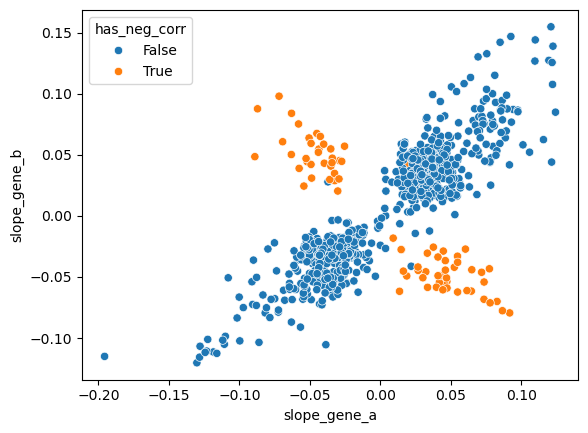

In [21]:
# 2 gene clusters
lead_var_grouped['cluster_size'] = lead_var_grouped['cluster_id'].str.split('_').apply(len)
lead_var_pair = lead_var_grouped[lead_var_grouped['cluster_size']==2]

# add the two slopes
lead_var_pair['slope_gene_a'] = lead_var_pair['eqtl_pip_weighted_slope'].str[0]
lead_var_pair['slope_gene_b'] = lead_var_pair['eqtl_pip_weighted_slope'].str[1]

# take multiegne pairs
lead_var_pair_multigene = lead_var_pair[lead_var_pair['num_e_samelead'] > 1]
sns.scatterplot(lead_var_pair_multigene, x='slope_gene_a', y='slope_gene_b', hue='has_neg_corr')

/local/scratch/klawren/slrmtmp.46840423/ipykernel_11554/1046643893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_var_pair_multigene['sign_flipped_slope_gene_b'] = np.where(lead_var_pair_multigene['slope_gene_a'] < 0, - lead_var_pair_multigene['slope_gene_b'], lead_var_pair_multigene['slope_gene_b'])
/local/scratch/klawren/slrmtmp.46840423/ipykernel_11554/1046643893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lead_var_pair_multigene['sign_flipped_slope_gene_a'] = np.where(lead_var_pair_mul

<AxesSubplot: xlabel='sign_flipped_slope_gene_b', ylabel='sign_flipped_slope_gene_a'>

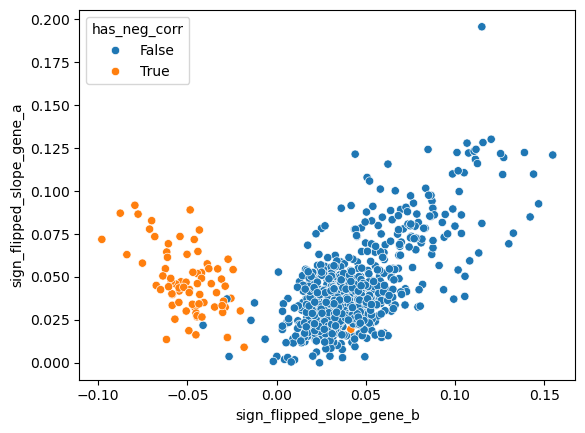

In [22]:
# make the sign relative to the slope a
lead_var_pair_multigene['sign_flipped_slope_gene_b'] = np.where(lead_var_pair_multigene['slope_gene_a'] < 0, - lead_var_pair_multigene['slope_gene_b'], lead_var_pair_multigene['slope_gene_b'])
lead_var_pair_multigene['sign_flipped_slope_gene_a'] = np.where(lead_var_pair_multigene['slope_gene_a'] < 0, - lead_var_pair_multigene['slope_gene_a'], lead_var_pair_multigene['slope_gene_a'])

sns.scatterplot(lead_var_pair_multigene, x='sign_flipped_slope_gene_b', y='sign_flipped_slope_gene_a', hue='has_neg_corr')

<AxesSubplot: xlabel='sign_flipped_slope_gene_b', ylabel='sign_flipped_slope_gene_a'>

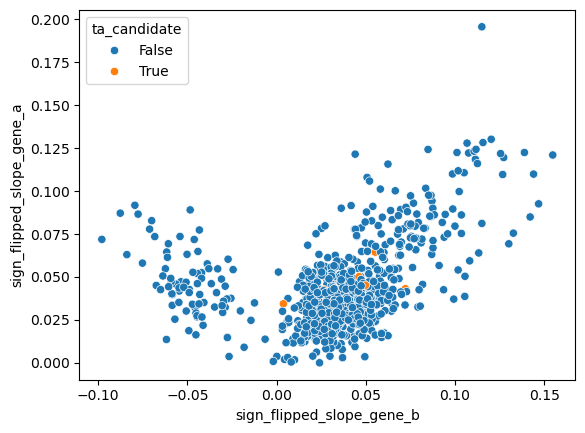

In [23]:
# chcke for TA in paralogs with NMD
lead_var_pair_multigene = pd.merge(lead_var_pair_multigene, susie_annotated.groupby('variant_id').agg({'vep_info':'first'}), left_on='lead_variant_id', right_on='variant_id', how='left')
lead_var_pair_multigene['has_nmd'] = lead_var_pair_multigene['vep_info'].str.contains('nonsense_mediated').fillna(False)
lead_var_pair_multigene['ta_candidate'] = lead_var_pair_multigene['has_nmd'] & lead_var_pair_multigene['has_paralog']
sns.scatterplot(lead_var_pair_multigene, x='sign_flipped_slope_gene_b', y='sign_flipped_slope_gene_a', hue='ta_candidate')

In [24]:
# whats with the positively correlated ones that have opposite effects?
lead_var_pair_multigene[(lead_var_pair_multigene['sign_flipped_slope_gene_b']<0) & ~(lead_var_pair_multigene['has_neg_corr'])][['has_nmd', 'has_paralog']]

,has_nmd,has_paralog
39,True,False
322,True,False
324,True,False
501,True,False
572,False,False
612,True,False
746,False,False


## eqtl effect size for all pcqtls 
previously, qtl effect sizes base on the signifigant credible sets. now, map back into eqtl space even for pcqtls without an overalpping eqtl hit

In [26]:
# weight the eqene_qtl_slope by the pcqtl credible set pip
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].apply(literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].apply(literal_eval)

# expand out over all egnees for a given pcqtl
susie_annotated_egene_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_id_list'])

# weight by pip
susie_annotated_egene_explode['pcpip_weighted_eqtl_slope'] = susie_annotated_egene_explode['egene_qtl_slope']*susie_annotated_egene_explode['pip']

# group by credible sets and egene
cs_grouped_eqtl_mapped = susie_annotated_egene_explode.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'egene_id_list']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'pip_weighted_slope':sum, 
                                                                                  'pcpip_weighted_eqtl_slope':sum}).reset_index()

In [27]:
# look just at pairs at first
cs_grouped_eqtl_mapped_pairs = cs_grouped_eqtl_mapped[cs_grouped_eqtl_mapped['cluster_id'].str.split('_').apply(len) < 3]

In [28]:
cs_grouped_eqtl_mapped_pairs = cs_grouped_eqtl_mapped_pairs.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'egene_id_list':list,
                                                                                  'pcpip_weighted_eqtl_slope':list, 
                                                                                  'pip_weighted_slope':'first'}).reset_index()


# add the two slopes
cs_grouped_eqtl_mapped_pairs['slope_gene_a'] = cs_grouped_eqtl_mapped_pairs['pcpip_weighted_eqtl_slope'].str[0]
cs_grouped_eqtl_mapped_pairs['slope_gene_b'] = cs_grouped_eqtl_mapped_pairs['pcpip_weighted_eqtl_slope'].str[1]


Text(0, 0.5, 'slope weighted by credible set 2')

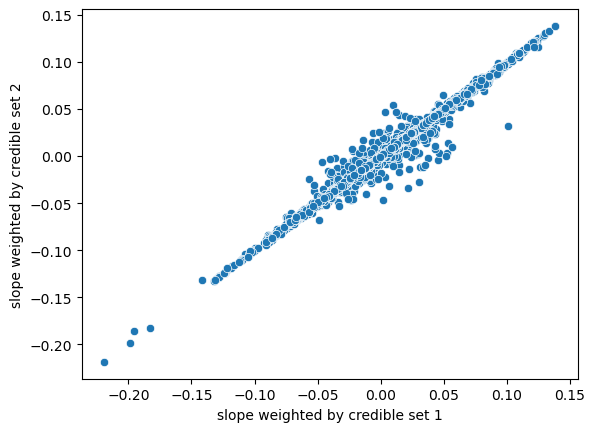

In [31]:
# check that all of the ones with the same lead var have the same pip weighted slope
test_group = cs_grouped_eqtl_mapped_pairs.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'slope_gene_a':list, 'slope_gene_b':list, 'egene_id_list':list, 'pip_weighted_slope':'first'})
test_group = test_group[test_group['slope_gene_a'].apply(len)>1]
test_group['slope_a'] = test_group['slope_gene_a'].str[0]
test_group['slope_b'] = test_group['slope_gene_a'].str[1]
ax = sns.scatterplot(test_group, x='slope_a', y='slope_b')
ax.set_xlabel('slope weighted by credible set 1')
ax.set_ylabel('slope weighted by credible set 2')

In [106]:
# group by lead varaint
# TODO replace with colocs
leadvar_grouped_eqtl_mapped_pairs = cs_grouped_eqtl_mapped_pairs.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'pcpip_weighted_eqtl_slope':'first', 
                                                                                          'pip_weighted_slope':list, 
                                                                                          'type':list, 
                                                                                          'cs_id':list}).reset_index()
# add number of pcqtl and eqtl label cols
leadvar_grouped_eqtl_mapped_pairs['num_e_samelead'] = leadvar_grouped_eqtl_mapped_pairs['cs_id'].astype(str).str.count('_e')
leadvar_grouped_eqtl_mapped_pairs['num_pc_samelead'] = leadvar_grouped_eqtl_mapped_pairs['cs_id'].astype(str).str.count('_pc')
leadvar_grouped_eqtl_mapped_pairs['exclusive_label'] = np.where((leadvar_grouped_eqtl_mapped_pairs['num_e_samelead'] > 0), np.where((leadvar_grouped_eqtl_mapped_pairs['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


In [107]:
# add the two slopes
leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'] = leadvar_grouped_eqtl_mapped_pairs['pcpip_weighted_eqtl_slope'].str[0]
leadvar_grouped_eqtl_mapped_pairs['slope_gene_b'] = leadvar_grouped_eqtl_mapped_pairs['pcpip_weighted_eqtl_slope'].str[1]

# make it so a is always the bigger one
# leadvar_grouped_eqtl_mapped_pairs['sign_flipped_slope_gene_b'] = np.where(leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'].abs() > leadvar_grouped_eqtl_mapped_pairs['slope_gene_b'].abs(), 
#                                                                           leadvar_grouped_eqtl_mapped_pairs['slope_gene_b'],
#                                                                           leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'])
# leadvar_grouped_eqtl_mapped_pairs['sign_flipped_slope_gene_a'] = np.where(leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'].abs() > leadvar_grouped_eqtl_mapped_pairs['slope_gene_b'].abs(), 
#                                                                           leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'],
#                                                                           leadvar_grouped_eqtl_mapped_pairs['slope_gene_b'])

# make the sign relative to the slope a
leadvar_grouped_eqtl_mapped_pairs['sign_flipped_slope_gene_b'] = np.where(leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'] < 0, - leadvar_grouped_eqtl_mapped_pairs['slope_gene_b'], leadvar_grouped_eqtl_mapped_pairs['slope_gene_b'])
leadvar_grouped_eqtl_mapped_pairs['sign_flipped_slope_gene_a'] = np.where(leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'] < 0, - leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'], leadvar_grouped_eqtl_mapped_pairs['slope_gene_a'])

# add cluster info
leadvar_grouped_eqtl_mapped_pairs = pd.merge(leadvar_grouped_eqtl_mapped_pairs, clusters, on=['cluster_id', 'tissue_id'], how='left')

<AxesSubplot: xlabel='sign_flipped_slope_gene_a', ylabel='sign_flipped_slope_gene_b'>

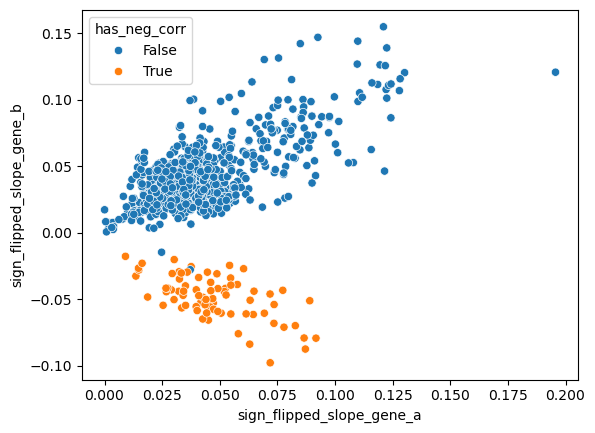

In [108]:
# the multigene ones
sns.scatterplot(leadvar_grouped_eqtl_mapped_pairs[leadvar_grouped_eqtl_mapped_pairs['num_e_samelead']>1], x='sign_flipped_slope_gene_a', y='sign_flipped_slope_gene_b', hue='has_neg_corr')

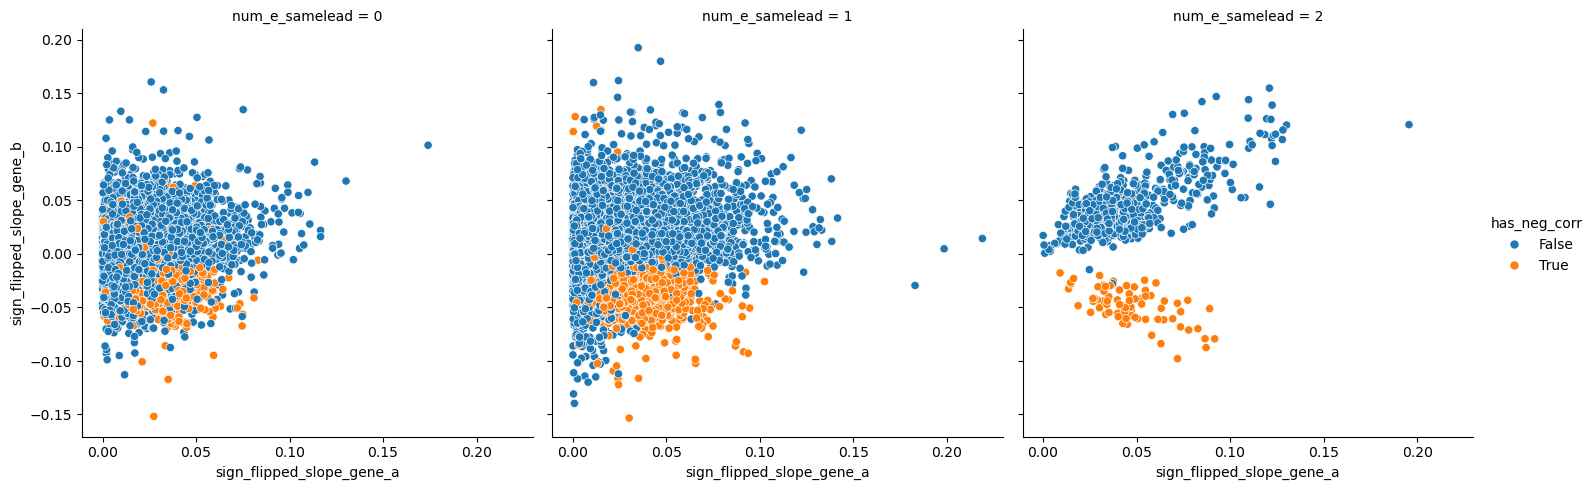

In [109]:
sns.relplot(leadvar_grouped_eqtl_mapped_pairs, x='sign_flipped_slope_gene_a', y='sign_flipped_slope_gene_b', col='num_e_samelead', hue='has_neg_corr', kind='scatter')

In [110]:
# chcke for TA in paralogs with NMD
leadvar_grouped_eqtl_mapped_pairs = pd.merge(leadvar_grouped_eqtl_mapped_pairs, susie_annotated.groupby('variant_id').agg({'vep_info':'first'}), left_on='lead_variant_id', right_on='variant_id', how='left')
leadvar_grouped_eqtl_mapped_pairs['has_nmd'] = leadvar_grouped_eqtl_mapped_pairs['vep_info'].str.contains('nonsense_mediated').fillna(False)
leadvar_grouped_eqtl_mapped_pairs['ta_candidate'] = leadvar_grouped_eqtl_mapped_pairs['has_nmd'] & lead_var_pair_multigene['has_paralog']


In [111]:
leadvar_grouped_eqtl_mapped_pairs[leadvar_grouped_eqtl_mapped_pairs['ta_candidate']][['sign_flipped_slope_gene_a','sign_flipped_slope_gene_b', 'has_neg_corr', 'num_e_samelead']]

,sign_flipped_slope_gene_a,sign_flipped_slope_gene_b,has_neg_corr,num_e_samelead
28,0.032033,-0.010025,False,0
36,0.007870,0.000969,False,1
56,0.006832,-0.011170,False,1
57,0.008517,-0.008173,False,1
58,0.002554,0.025598,False,0
59,0.029512,0.041007,False,0
116,0.005561,-0.032204,False,0
117,0.012902,0.003193,False,1
373,0.048360,0.022303,False,1
420,0.048723,0.045055,False,0


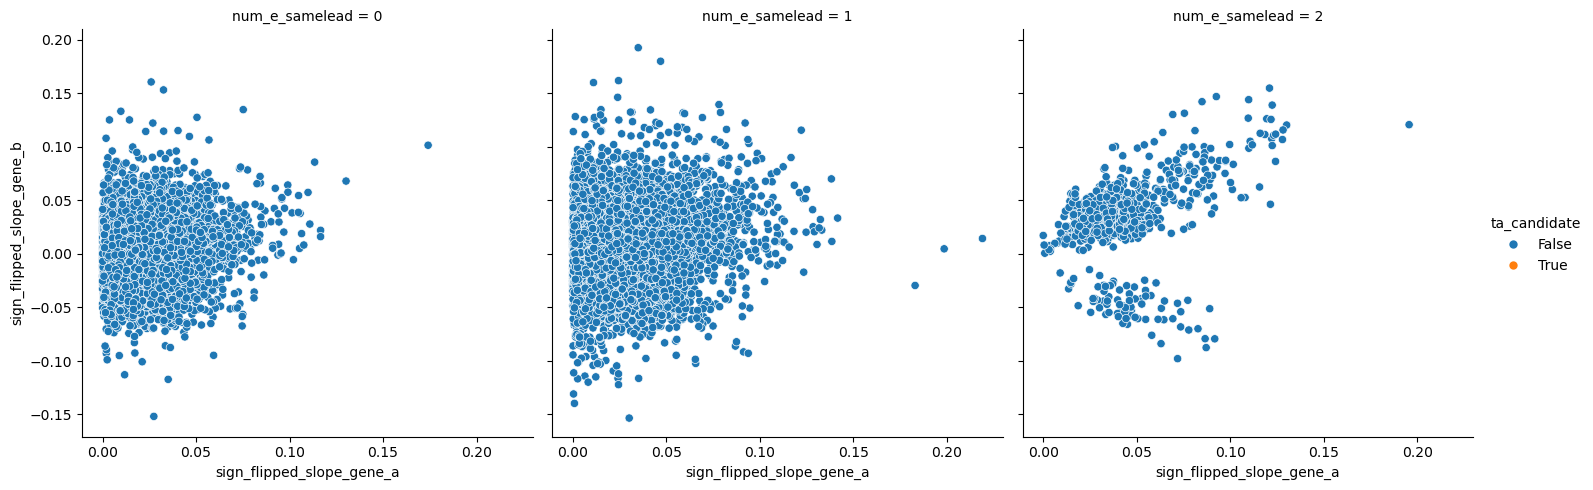

In [112]:
sns.relplot(leadvar_grouped_eqtl_mapped_pairs, x='sign_flipped_slope_gene_a', y='sign_flipped_slope_gene_b', col='num_e_samelead', hue='ta_candidate', kind='scatter')

### annotations by radial angle

In [113]:
# Function to convert Cartesian to Polar
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)  # theta in radians
    return r, theta

# Apply the function to the DataFrame
leadvar_grouped_eqtl_mapped_pairs['eqtl_effect_r'], leadvar_grouped_eqtl_mapped_pairs['eqtl_effect_theta'] = zip(*leadvar_grouped_eqtl_mapped_pairs.progress_apply(lambda row: cartesian_to_polar(row['sign_flipped_slope_gene_a'], row['sign_flipped_slope_gene_b']), axis=1))


100%|████████████████████████████████████████████████████████████████████████████████████████████| 25185/25185 [00:00<00:00, 54745.48it/s]


In [114]:
susie_annotated['vep_nmd'] = susie_annotated['vep_info'].str.contains('NMD_transcript_variant')
susie_annotated['vep_enhancer'] = susie_annotated['vep_info'].str.contains('enhancer')
susie_annotated['vep_promoter'] = susie_annotated['vep_info'].str.contains('promoter')
susie_annotated['vep_CTCF'] = susie_annotated['vep_info'].str.contains('CTCF_binding_site')
susie_annotated['vep_TF'] = susie_annotated['vep_info'].str.contains('TF_binding_site')
susie_annotated['vep_open_chrom'] = susie_annotated['vep_info'].str.contains('open_chromatin_region')
susie_annotated['vep_reg'] = susie_annotated['vep_info'].str.contains('regulatory_region_variant')

# add other annotation cats
susie_annotated['in_enhancer'] = (susie_annotated['qtl_num_abc_enhancers'] > 0)
susie_annotated['in_matched_enhancer'] = (susie_annotated['qtl_matched_abc_genes'] > 0)
susie_annotated['in_multiple_matched_enhancer'] = (susie_annotated['qtl_matched_abc_genes'] > 1)

In [115]:
col_names = ['in_enhancer', 'in_matched_enhancer', 'in_multiple_matched_enhancer', 'in_bidirectional_promoter', 'in_shared_promoter', 
              'qtl_in_ctcf', 'qtl_in_tad', 'qtl_in_tad_ctcf', 'vep_nmd', 'vep_enhancer', 'vep_promoter', 'vep_CTCF', 'vep_TF', 'vep_open_chrom', 'vep_reg']

pip_weighted_col_names = []
for col in col_names:
    pip_weighted_col_names.append(f'pip_{col}')
    susie_annotated[f'pip_{col}'] = susie_annotated[col] * susie_annotated['pip']

mean_agg_dict = dict([(col, 'mean') for col in pip_weighted_col_names])
susie_annotated.groupby('type').agg(mean_agg_dict)

# group over credible sets
sum_agg_dict = dict([(col, 'sum') for col in pip_weighted_col_names])
sum_agg_dict['type'] = 'first'
sum_agg_dict['cluster_id'] = 'first'
sum_agg_dict['lead_variant_id'] = 'first'
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg(sum_agg_dict).reset_index()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
    # split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'

cs_grouped.groupby('pc_order').agg(mean_agg_dict)
lead_var_grouped_annotated = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg(mean_agg_dict).reset_index()

In [116]:
lead_var_grouped_annotated = lead_var_grouped_annotated[lead_var_grouped_annotated['cluster_id'].str.split('_').apply(len) == 2]
leadvar_grouped_eqtl_mapped_pairs = pd.merge(lead_var_grouped_annotated, leadvar_grouped_eqtl_mapped_pairs, left_on = ['lead_variant_id', 'tissue_id', 'cluster_id'], right_on=['lead_variant_id', 'tissue_id', 'cluster_id'])

In [117]:
# add the susie annotations
leadvar_grouped_eqtl_mapped_pairs.columns

Index(['lead_variant_id', 'tissue_id', 'cluster_id', 'pip_in_enhancer',
       'pip_in_matched_enhancer', 'pip_in_multiple_matched_enhancer',
       'pip_in_bidirectional_promoter', 'pip_in_shared_promoter',
       'pip_qtl_in_ctcf', 'pip_qtl_in_tad', 'pip_qtl_in_tad_ctcf',
       'pip_vep_nmd', 'pip_vep_enhancer', 'pip_vep_promoter', 'pip_vep_CTCF',
       'pip_vep_TF', 'pip_vep_open_chrom', 'pip_vep_reg',
       'pcpip_weighted_eqtl_slope', 'pip_weighted_slope', 'type', 'cs_id',
       'num_e_samelead', 'num_pc_samelead', 'exclusive_label', 'slope_gene_a',
       'slope_gene_b', 'sign_flipped_slope_gene_b',
       'sign_flipped_slope_gene_a', 'N_genes', 'Transcripts', 'Perc_cor',
       'Mean_cor', 'Mean_pos_cor', 'Mean_neg_cor', 'Chromosome', 'Tissue',
       'cluster_size', 'cluster_tss_size', 'start', 'end', 'tss_min',
       'tss_max', 'tss_inter', 'gene_inter', 'num_tads_gene', 'num_tads_tss',
       'has_tads_gene', 'has_tads_tss', 'num_bidirectional_promoter',
       'has_bidi

In [105]:
mean_agg_dict

{'pip_in_enhancer': 'mean',
 'pip_in_matched_enhancer': 'mean',
 'pip_in_multiple_matched_enhancer': 'mean',
 'pip_in_bidirectional_promoter': 'mean',
 'pip_in_shared_promoter': 'mean',
 'pip_qtl_in_ctcf': 'mean',
 'pip_qtl_in_tad': 'mean',
 'pip_qtl_in_tad_ctcf': 'mean',
 'pip_vep_nmd': 'mean',
 'pip_vep_enhancer': 'mean',
 'pip_vep_promoter': 'mean',
 'pip_vep_CTCF': 'mean',
 'pip_vep_TF': 'mean',
 'pip_vep_open_chrom': 'mean',
 'pip_vep_reg': 'mean'}

<AxesSubplot: xlabel='eqtl_effect_theta', ylabel='Percent'>

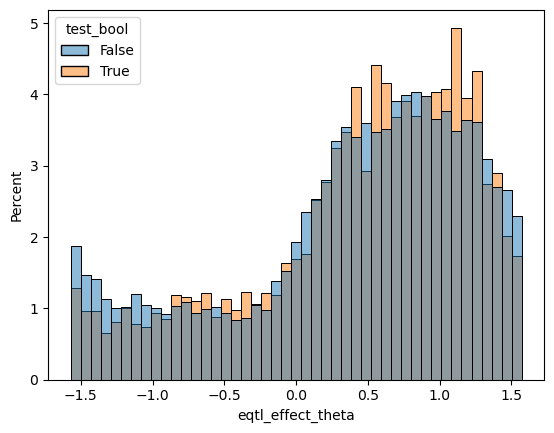

In [145]:
leadvar_grouped_eqtl_mapped_pairs['test_bool'] = leadvar_grouped_eqtl_mapped_pairs['pip_qtl_in_tad'] > 0
sns.histplot(leadvar_grouped_eqtl_mapped_pairs, x='eqtl_effect_theta', hue='test_bool', common_norm=False, stat='percent')

<AxesSubplot: xlabel='eqtl_effect_theta', ylabel='Count'>

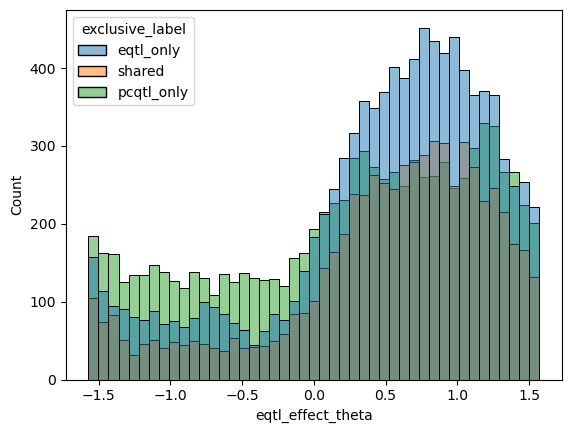

In [71]:
sns.histplot(leadvar_grouped_eqtl_mapped_pairs, x='eqtl_effect_theta', hue='exclusive_label')

<AxesSubplot: xlabel='eqtl_effect_r', ylabel='Count'>

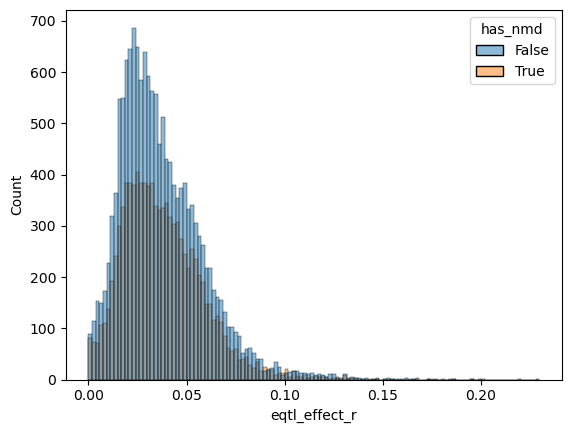

In [74]:
sns.histplot(leadvar_grouped_eqtl_mapped_pairs, x='eqtl_effect_r', hue='has_nmd')

<AxesSubplot: xlabel='eqtl_effect_theta', ylabel='Count'>

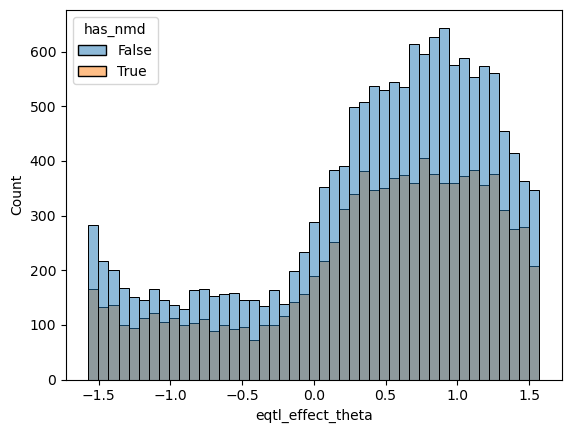

In [81]:
sns.histplot(leadvar_grouped_eqtl_mapped_pairs, x='eqtl_effect_theta', hue='has_nmd')

In [134]:
# Define the independent variables and dependent variable
leadvar_grouped_eqtl_mapped_pairs['pcqtl_bool'] = leadvar_grouped_eqtl_mapped_pairs['type'].astype(str).str.contains('pcqtl')
X = leadvar_grouped_eqtl_mapped_pairs[['test_bool']].astype(int)
y = leadvar_grouped_eqtl_mapped_pairs['eqtl_effect_theta']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      eqtl_effect_theta   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     36.49
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           1.56e-09
Time:                        13:37:53   Log-Likelihood:                -30631.
No. Observations:               25185   AIC:                         6.127e+04
Df Residuals:                   25183   BIC:                         6.128e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3626      0.007     51.975      0.0

## what predicts qtl effect size?

In [37]:
# start with positive pairs only
pos_pairs = lead_var_pair_annotated[~lead_var_pair_annotated['has_neg_corr']]

In [38]:
# given slope for gene a, predict slope for gene b
import statsmodels.api as sm
X = pos_pairs[['sign_flipped_slope_gene_b', 'Mean_cor']]
X = sm.add_constant(X)
y = pos_pairs['sign_flipped_slope_gene_a']
model = sm.OLS(y, X).fit()

print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     sign_flipped_slope_gene_a   R-squared:                       0.488
Model:                                   OLS   Adj. R-squared:                  0.486
Method:                        Least Squares   F-statistic:                     314.5
Date:                       Mon, 28 Oct 2024   Prob (F-statistic):           1.08e-96
Time:                               17:22:34   Log-Likelihood:                 1730.1
No. Observations:                        664   AIC:                            -3454.
Df Residuals:                            661   BIC:                            -3441.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [75]:
# runrun qtl annotation to get this
#susie_annotated['cluster_min_distance']

In [77]:
# add in some lead var annotations
pos_pairs_annotated = pd.merge(pos_pairs, susie_annotated[['variant_id', 'tissue_id', 'cluster_id', 'vep_info', 'in_shared_promoter','in_bidirectional_promoter','qtl_num_abc_enhancers','between_tss',]].drop_duplicates(),
         left_on=['lead_variant_id', 'tissue_id', 'cluster_id'], right_on=['variant_id', 'tissue_id', 'cluster_id'], how='left')

In [82]:
# given slope for gene a, predict slope for gene b
import statsmodels.api as sm
X = pos_pairs_annotated[['sign_flipped_slope_gene_b', 'between_tss']].astype(float)
X = sm.add_constant(X)
y = pos_pairs_annotated['sign_flipped_slope_gene_a']
model = sm.OLS(y, X).fit()

print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     sign_flipped_slope_gene_a   R-squared:                       0.484
Model:                                   OLS   Adj. R-squared:                  0.482
Method:                        Least Squares   F-statistic:                     309.7
Date:                       Mon, 28 Oct 2024   Prob (F-statistic):           1.24e-95
Time:                               17:36:41   Log-Likelihood:                 1727.7
No. Observations:                        664   AIC:                            -3449.
Df Residuals:                            661   BIC:                            -3436.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

## old code 
this is automated as part of qtl annotations now

In [3]:
def add_variance(nominal_df):
    nominal_df['variance'] = nominal_df['slope'].apply(np.square) * 100

def get_var_explained(row, nominal_df):
    var_list = row['variant_id']
    pip_list = row['pip']
    # make sure all varaints are in the nominal df
    try:
        nominal_df['variance']
    except KeyError:
        add_variance(nominal_df)
    sub_nominal = nominal_df.loc[var_list]
    sub_nominal = sub_nominal[sub_nominal['cluster_id'] == row['cluster_id']]
    # add pips to the df    
    sub_nominal = sub_nominal.merge(pd.Series(pip_list, index=pd.Series(var_list, name='variant_id'), name='pip'), on='variant_id')
    sub_nominal['variance_weighted'] = sub_nominal['variance'] * sub_nominal['pip']
    # sum over each phenotype to get the total weighted varience
    return sub_nominal.groupby('phenotype_id').agg({'variance_weighted':'sum'}).reset_index()


def get_slope_pip_weighted(row, nominal_df):
    var_list = row['variant_id']
    pip_list = row['pip']
    # make sure all varaints are in the nominal df
    sub_nominal = nominal_df.loc[var_list]
    sub_nominal = sub_nominal[sub_nominal['cluster_id'] == row['cluster_id']]
    # add pips to the df    
    sub_nominal = sub_nominal.merge(pd.Series(pip_list, index=pd.Series(var_list, name='variant_id'), name='pip'), on='variant_id')
    sub_nominal['slope_weighted'] = sub_nominal['slope'] * sub_nominal['pip']
    # sum over each phenotype to get the total weighted varience
    return sub_nominal.groupby('phenotype_id').agg({'slope_weighted':'sum'}).reset_index()


def add_pip_weighted_slope(cs_grouped_pc_susie, vid_pc_nominal, vid_e_nominal):
    for idx, row in tqdm(cs_grouped_pc_susie.iterrows(), total=len(cs_grouped_pc_susie)):
        pc_slope_weighted = get_slope_pip_weighted(row, vid_pc_nominal)
        try:
            cs_grouped_pc_susie.loc[idx, 'matching_pc_slope'] = pc_slope_weighted[pc_slope_weighted['phenotype_id'].str.split('_pc').str[-1] == str(row['pc_num'])].iloc[0]['slope_weighted']
        except IndexError as e:
            print(pc_slope_weighted)
            print(pc_slope_weighted['phenotype_id'])
            print(row['pc_num'])
            raise e
        e_var_weighted = get_slope_pip_weighted(row, vid_e_nominal)
        cs_grouped_pc_susie.loc[idx, 'e_slope'] = str(e_var_weighted['slope_weighted'].to_list())
        cs_grouped_pc_susie.loc[idx, 'e_slope_phenotypes'] = str(e_var_weighted['phenotype_id'].to_list())

    cs_grouped_pc_susie['e_slope_max'] = [max(ast.literal_eval(e_slope), key=abs) for e_slope in cs_grouped_pc_susie['e_slope']]
    cs_grouped_pc_susie['e_slope_average'] = [np.mean(ast.literal_eval(e_slope)) for e_slope in cs_grouped_pc_susie['e_slope']]
    return cs_grouped_pc_susie


def add_sign_flipped_slopes(config, my_tissue_id, annot_cs_grouped_pc_susie):
    pc_df = load_pc(config, my_tissue_id)
    expression_df = load_cluster_expression(config, my_tissue_id)  
    sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]

    # add the slopes to the pc df
    for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
        expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
        gene_slopes = []
        gene_variances = []
        for egene_id in row['cluster_id'].split('_'):
            expression_values = expression_cluster[expression_cluster['egene_id']==egene_id][sample_ids].values.astype('float')            # pull the right data
            pc_values = row[sample_ids].astype('float')
            # get the r squared value
            slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
            gene_slopes.append(slope)
            gene_variances.append((r_value**2)*100)
        pc_df.loc[idx, 'variance_list'] = str(gene_variances)
        pc_df.loc[idx, 'slope_list'] = str(gene_slopes)

    pc_df['variance_list_explode'] = pc_df['variance_list'].apply(ast.literal_eval)
    pc_df['slope_list_explode'] = pc_df['slope_list'].apply(ast.literal_eval)
    pc_df['transcript_list_explode'] = pc_df['cluster_id'].str.split('_')

    # flip the signs for pc-e pairs with negative slopes 
    for idx, row in tqdm(annot_cs_grouped_pc_susie.iterrows(), total=len(annot_cs_grouped_pc_susie)):
        matching_pc_df_row = pc_df[pc_df['gene_id'] == row['pc_id']].explode(['slope_list_explode', 'transcript_list_explode', 'variance_list_explode'])
        pc_egene_slopes=[]
        pc_egene_vars = []
        for e_phenotype in ast.literal_eval(row['e_slope_phenotypes']):
            egene_id = e_phenotype.split('_e_')[-1]
            pc_egene_slopes.append(matching_pc_df_row[matching_pc_df_row['transcript_list_explode'] == egene_id]['slope_list_explode'].iloc[0])
            pc_egene_vars.append(matching_pc_df_row[matching_pc_df_row['transcript_list_explode'] == egene_id]['variance_list_explode'].iloc[0])

        annot_cs_grouped_pc_susie.loc[idx, 'pc_egene_slopes'] = str(pc_egene_slopes)
        annot_cs_grouped_pc_susie.loc[idx, 'pc_egene_vars'] = str(pc_egene_vars)

        sign_flipped_slopes = np.asarray(ast.literal_eval(row['e_slope'])) * np.asarray([1 if p>0 else -1 for p in pc_egene_slopes])
        annot_cs_grouped_pc_susie.loc[idx, 'e_slope_sign_flipped'] = str(sign_flipped_slopes.tolist())
        annot_cs_grouped_pc_susie.loc[idx, 'e_slope_slope_weighted'] = str((np.asarray(ast.literal_eval(row['e_slope'])) * np.asarray(pc_egene_slopes)).tolist())
        annot_cs_grouped_pc_susie.loc[idx, 'e_slope_var_weighted'] = str((np.asarray(sign_flipped_slopes) * np.asarray(pc_egene_vars)).tolist())



In [4]:
def get_annotated_pc_susie(config, my_tissue_id, plot=False):
    print(my_tissue_id)

    e_nominal = load_e_nominal_all_chr(config, my_tissue_id)
    pc_nominal = load_pc_nominal_all_chr(config, my_tissue_id)
    pc_susie = load_pc_susie(config, my_tissue_id)
    pc_susie['chr'] = pc_susie['variant_id'].str.split('chr').str[1].str.split('_').str[0]
    print("\tloaded data")

    vid_pc_nominal = pc_nominal.set_index('variant_id')
    vid_pc_nominal = vid_pc_nominal.loc[pc_susie['variant_id']]
    if plot:
        sns.histplot(vid_pc_nominal, x='slope')
        plt.show()

    vid_e_nominal = e_nominal.set_index('variant_id')
    vid_e_nominal = vid_e_nominal.loc[pc_susie['variant_id']]


    # this is on the level of the credible set, so group the susie output by credible set
    cs_grouped_pc_susie = pc_susie.groupby('cs_id').agg({'pip':list, 
                                'variant_id': list,
                                'cs_num':'first',
                                'pc_num':'first',
                                'lead_variant_id':'first',
                                'num_vars':'first',
                                'cluster_id':'first', 
                                'chr':'first'})
    print("\tannotating credible sets with slopes")
    cs_grouped_pc_susie = add_pip_weighted_slope(cs_grouped_pc_susie, vid_pc_nominal, vid_e_nominal)

    if plot:
        ax = sns.histplot(cs_grouped_pc_susie, x='e_slope_max')
        plt.xlabel('pip weighted slope')
        plt.show()
        ax = sns.scatterplot(cs_grouped_pc_susie, x='e_slope_max', y='matching_pc_slope')
        plt.show()

    # add in credible set overlap information
    print("\tannotating credible sets with overlap df")
    overlap = load_overlap(config, my_tissue_id)
    overlap['cs_id'] = overlap['cs_full_id'].str.split('cs').str.join('')
    annot_cs_grouped_pc_susie = pd.merge(cs_grouped_pc_susie, overlap[['num_e_samelead', 'num_pc_samelead', 'num_pc_overlap', 'num_e_overlap', 'cs_id', 'e_overlap']], on='cs_id', how='left')

    # add in cluster info 
    print("\tannotating credible sets with cluster df")
    cluster_df = load_clusters_annotated(config, my_tissue_id)
    annot_cs_grouped_pc_susie = pd.merge(annot_cs_grouped_pc_susie, cluster_df, on='cluster_id', how='left')

    annot_cs_grouped_pc_susie['abs_cor'] = np.where(annot_cs_grouped_pc_susie['Mean_neg_cor'].isna(), annot_cs_grouped_pc_susie['Mean_pos_cor'], - annot_cs_grouped_pc_susie['Mean_neg_cor'])
    annot_cs_grouped_pc_susie['abs_cor'] = np.where(annot_cs_grouped_pc_susie['abs_cor'] < annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['abs_cor'])

    annot_cs_grouped_pc_susie['max_pos_neg_cor'] = np.where(annot_cs_grouped_pc_susie['Mean_neg_cor'].isna(), annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_neg_cor'])
    annot_cs_grouped_pc_susie['max_pos_neg_cor'] = np.where(abs(annot_cs_grouped_pc_susie['max_pos_neg_cor']) < annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['Mean_pos_cor'], annot_cs_grouped_pc_susie['max_pos_neg_cor'])
    annot_cs_grouped_pc_susie['pc_id'] = annot_cs_grouped_pc_susie['cs_id'].str.replace(r'(_\d+)$', '', regex=True)

    # add in sign flipped slopes 
    add_sign_flipped_slopes(config, my_tissue_id, annot_cs_grouped_pc_susie)

    return annot_cs_grouped_pc_susie

In [5]:
test_annot_cs_grouped_pc_susie = get_annotated_pc_susie(config, 'Muscle_Skeletal')

Muscle_Skeletal
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [01:32<00:00, 17.38it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [00:14<00:00, 113.71it/s]


<AxesSubplot: xlabel='e_slope_explode', ylabel='matching_pc_slope'>

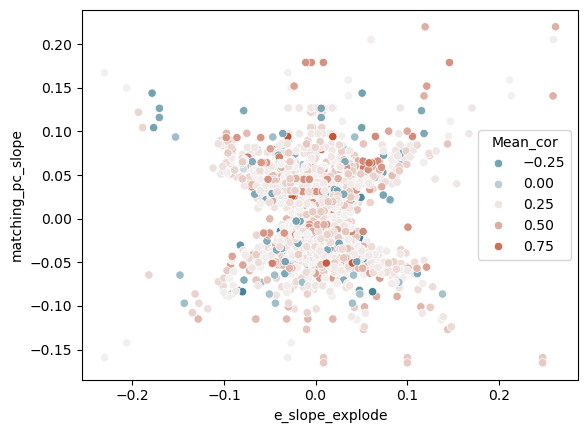

In [6]:
test_annot_cs_grouped_pc_susie['e_slope_explode'] = test_annot_cs_grouped_pc_susie['e_slope'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_explode'), x='e_slope_explode', y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot: xlabel='e_slope_sign_flipped_explode', ylabel='matching_pc_slope'>

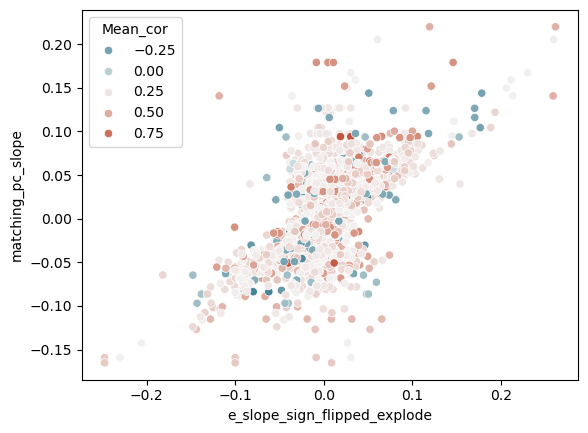

In [7]:
test_annot_cs_grouped_pc_susie['e_slope_sign_flipped_explode'] = test_annot_cs_grouped_pc_susie['e_slope_sign_flipped'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_sign_flipped_explode'), x='e_slope_sign_flipped_explode', y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot: xlabel='e_slope_slope_weighted_explode', ylabel='matching_pc_slope'>

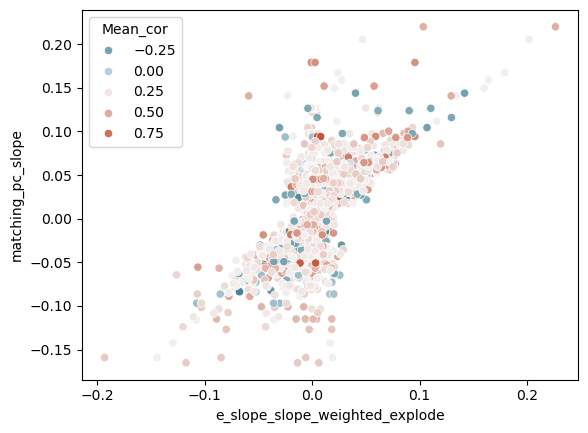

In [8]:
test_annot_cs_grouped_pc_susie['e_slope_slope_weighted_explode'] = test_annot_cs_grouped_pc_susie['e_slope_slope_weighted'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_slope_weighted_explode'), x='e_slope_slope_weighted_explode', 
                y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot: xlabel='e_slope_var_weighted_explode', ylabel='matching_pc_slope'>

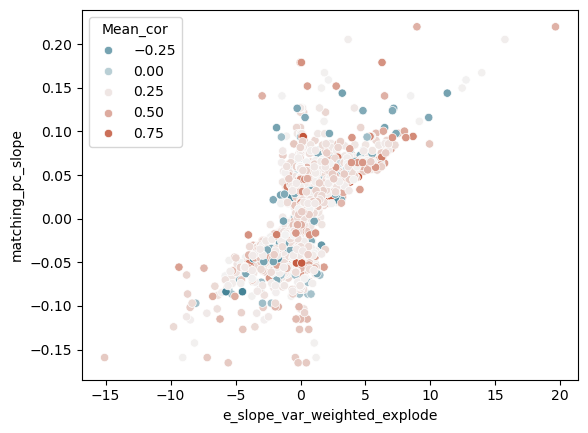

In [9]:
test_annot_cs_grouped_pc_susie['e_slope_var_weighted_explode'] = test_annot_cs_grouped_pc_susie['e_slope_var_weighted'].apply(ast.literal_eval)
sns.scatterplot(test_annot_cs_grouped_pc_susie.explode('e_slope_var_weighted_explode'), x='e_slope_var_weighted_explode', y='matching_pc_slope', hue='Mean_cor', palette=sns.diverging_palette(220, 20, as_cmap=True))

## combine across tissues

In [10]:
# get it for all the tissues
annot_cs_grouped_pc_susie = load_across_tissues(config, get_annotated_pc_susie)

Adipose_Subcutaneous
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1578/1578 [01:26<00:00, 18.33it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1578/1578 [00:13<00:00, 112.88it/s]


Adipose_Visceral_Omentum
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1045/1045 [00:44<00:00, 23.33it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1045/1045 [00:09<00:00, 115.01it/s]


Artery_Tibial
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1652/1652 [01:28<00:00, 18.70it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1652/1652 [00:14<00:00, 117.15it/s]


Cells_Cultured_fibroblasts
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1674/1674 [01:05<00:00, 25.46it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1674/1674 [00:14<00:00, 113.92it/s]


Esophagus_Mucosa
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1421/1421 [01:18<00:00, 18.16it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1421/1421 [00:12<00:00, 116.10it/s]


Esophagus_Muscularis
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1182/1182 [00:45<00:00, 26.14it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1182/1182 [00:09<00:00, 119.63it/s]


Lung
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1230/1230 [01:02<00:00, 19.79it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1230/1230 [00:11<00:00, 104.92it/s]


Muscle_Skeletal
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [01:29<00:00, 18.04it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1611/1611 [00:14<00:00, 115.01it/s]


Nerve_Tibial
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1787/1787 [01:25<00:00, 20.94it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1787/1787 [00:14<00:00, 120.83it/s]


Skin_Not_Sun_Exposed_Suprapubic
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1364/1364 [01:20<00:00, 16.99it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1364/1364 [00:11<00:00, 117.77it/s]


Skin_Sun_Exposed_Lower_leg
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1804/1804 [01:51<00:00, 16.16it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1804/1804 [00:14<00:00, 122.60it/s]


Thyroid
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2168/2168 [02:17<00:00, 15.76it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2168/2168 [00:17<00:00, 123.11it/s]


Whole_Blood
	loaded data
	annotating credible sets with slopes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [01:28<00:00, 19.01it/s]


	annotating credible sets with overlap df
	annotating credible sets with cluster df


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:14<00:00, 119.00it/s]


In [13]:
import os
os.makedirs(f'{prefix}/temp/')
annot_cs_grouped_pc_susie.to_csv(f'{prefix}/temp/effect_size_annotated_overlap_all_tissues.txt', sep='\t')

In [5]:
annot_cs_grouped_pc_susie = pd.read_csv(f'{prefix}/temp/effect_size_annotated_overlap_all_tissues.txt', sep='\t', index_col=0)

In [6]:
# effect size differences here?
annot_cs_grouped_pc_susie['exclusive_label'] = np.where((annot_cs_grouped_pc_susie['num_e_samelead'] > 0), np.where((annot_cs_grouped_pc_susie['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')
annot_cs_grouped_pc_susie['pc_egene_vars'] =  annot_cs_grouped_pc_susie['pc_egene_vars'].apply(ast.literal_eval)

In [7]:
annot_cs_grouped_pc_susie['effect_size'] = annot_cs_grouped_pc_susie['e_slope_max']**2

In [8]:
annot_cs_grouped_pc_susie['max_egene_var'] = annot_cs_grouped_pc_susie['pc_egene_vars'].apply(max)

Text(0.5, 0, 'maximum egene % variance explained')

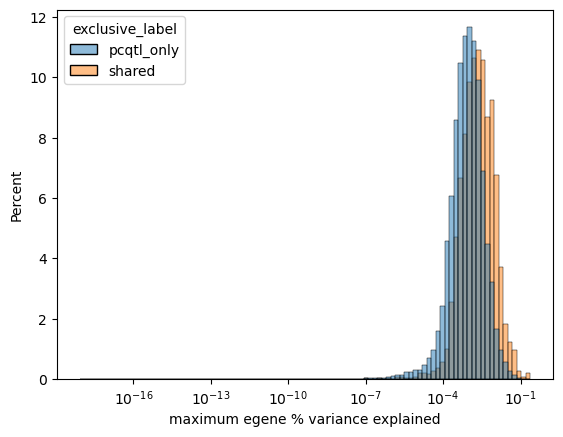

In [9]:
ax = sns.histplot(annot_cs_grouped_pc_susie, x='effect_size', hue='exclusive_label', log_scale=True, common_norm=False, bins=100, stat='percent')
ax.set_xlabel('maximum egene % variance explained')

look at just those that impact multiple genes. are the genes more correlated?

<AxesSubplot: xlabel='max_pos_neg_cor', ylabel='Percent'>

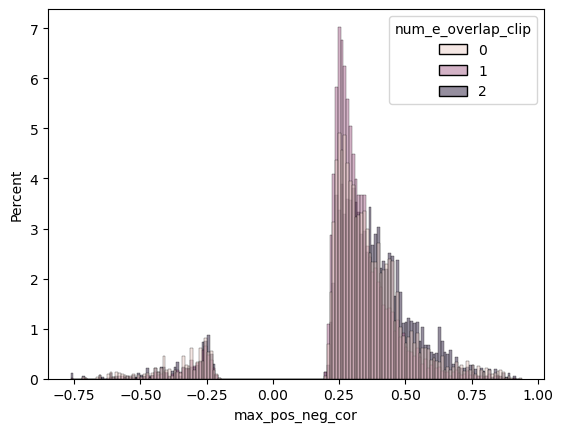

In [10]:
annot_cs_grouped_pc_susie['num_e_overlap_clip'] = annot_cs_grouped_pc_susie['num_e_overlap'].clip(0,2) 
sns.histplot(annot_cs_grouped_pc_susie, x='max_pos_neg_cor', hue='num_e_overlap_clip', common_norm=False, stat='percent')

In [39]:
annot_cs_grouped_pc_susie

,cs_id,pip,variant_id,cs_num,pc_num,lead_variant_id,num_vars,cluster_id,chr,matching_pc_slope,...,pc_egene_slopes,pc_egene_vars,e_slope_sign_flipped,e_slope_slope_weighted,e_slope_var_weighted,tissue_id,exclusive_label,effect_size,max_egene_var,num_e_overlap_clip
0,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,"[0.2690568, 0.20032704, 0.1347186, 0.2936548, ...","['chr1_196853900_T_G_b38', 'chr1_196856834_A_G...",1,1,chr1_196868521_T_C_b38,6,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,0.027087,...,"[-0.7409920992319063, -0.7250957714408917, -0....","[54.90693844207257, 52.57639227791427, 50.1213...","[0.008206389740088442, 0.030390197968480494, 0...","[0.006080869960623313, 0.022035804040196783, 0...","[0.450587736290692, 1.5978069697943038, 0.4938...",Adipose_Subcutaneous,pcqtl_only,0.000924,54.906938,1
1,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,"[0.021360993, 0.021360993, 0.017427087, 0.0213...","['chr1_196382020_A_C_b38', 'chr1_196388616_A_G...",2,1,chr1_196447806_GAC_G_b38,30,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,-0.024098,...,"[-0.7409920992319063, -0.7250957714408917, -0....","[54.90693844207257, 52.57639227791427, 50.1213...","[-0.025184353993623624, -0.016320965500357987,...","[-0.018661407333534615, -0.011834263070142252,...","[-1.382795774431257, -0.858097484501127, -0.95...",Adipose_Subcutaneous,shared,0.000634,54.906938,2
2,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,[0.98504657],['chr1_196740093_A_T_b38'],1,2,chr1_196740093_A_T_b38,1,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,0.022094,...,"[0.467802467586444, -0.4842826481835277, 0.529...","[21.88391860969454, 23.452970366185593, 28.073...","[-0.0071030522034998145, 0.032127369483383406,...","[-0.003322825348192542, 0.015558727572583569, ...","[-0.1554426163018014, 0.7534822444372864, -0.2...",Adipose_Subcutaneous,shared,0.001032,28.140731,1
3,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,"[0.0302248, 0.010810018, 0.010810018, 0.009014...","['chr1_196382020_A_C_b38', 'chr1_196382636_A_T...",2,2,chr1_196402302_T_C_b38,38,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,1,0.002323,...,"[0.467802467586444, -0.4842826481835277, 0.529...","[21.88391860969454, 23.452970366185593, 28.073...","[0.0060826177540127205, -0.0048195147676156555...","[0.0028454635947122646, -0.0023340073746205285...","[0.13311151186269737, -0.11303193702428381, 0....",Adipose_Subcutaneous,shared,0.000037,28.140731,2
4,ENSG00000001460.17_ENSG00000001461.16_pc1_1,"[0.013464093, 0.0626955, 0.0626955, 0.0626955,...","['chr1_24402426_ATCT_A_b38', 'chr1_24405169_G_...",1,1,chr1_24415329_A_G_b38,12,ENSG00000001460.17_ENSG00000001461.16,1,-0.040837,...,"[0.8137592721605411, 0.8137591567245858]","[66.22040794940062, 66.2203952962003]","[-0.040074593443185015, -0.026389189318771454]","[-0.03261107199245583, -0.021474444446688903]","[-2.653755926214087, -1.7475025482353121]",Adipose_Subcutaneous,shared,0.001606,66.220408,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20199,ENSG00000276070.4_ENSG00000276085.1_pc1_2,[0.9984328],['chr17_36182122_G_T_b38'],2,1,chr17_36182122_G_T_b38,1,ENSG00000276070.4_ENSG00000276085.1,17,-0.043498,...,"[-0.9373685404437381, -0.937368440872092]","[87.865976090035, 87.8659716422175]","[-0.02990945272374153, -0.05163762853219509]","[-0.028036180045124585, -0.04840348334755597]","[-2.6280232578903058, -4.5371904042812155]",Whole_Blood,shared,0.002666,87.865976,1
20200,ENSG00000276070.4_ENSG00000276085.1_pc1_3,[0.99428946],['chr17_36467153_T_C_b38'],3,1,chr17_36467153_T_C_b38,1,ENSG00000276070.4_ENSG00000276085.1,17,0.060505,...,"[-0.9373685404437381, -0.937368440872092]","[87.865976090035, 87.8659716422175]","[0.0643565006165041, 0.04907368622873537]","[0.06032575905095897, 0.046000124748075924]","[5.6547467444080715, 4.311907122553142]",Whole_Blood,shared,0.004142,87.865976,1
20201,ENSG00000276070.4_ENSG00000276085.1_pc1_4,"[0.22711182, 0.3819728, 0.3819728]","['chr17_36143679_A_G_

## multigene comparisions
take those that are called as eqtls for multiple genes.
look at how the effect size for 1 gene changes the effect size for the other

In [11]:
multiegene_cs_grouped = annot_cs_grouped_pc_susie[annot_cs_grouped_pc_susie['num_e_overlap']>1].reset_index(drop=True)
len(multiegene_cs_grouped)

3702

In [12]:
# look at the distribution of each slope vs the average slope. if an eqtl is shared, does it tend to impact all the genes roughly the same?

for idx, row in multiegene_cs_grouped.iterrows():
    egenes = [e_phenotype.split('_e_')[-1] for e_phenotype in ast.literal_eval(row['e_slope_phenotypes'])]
    sig_egenes = [e_phenotype.split('_e_')[1] for e_phenotype in ast.literal_eval(row['e_overlap'])]
    sig_egene_filter = pd.Series(egenes).isin(sig_egenes)
    sig_e_slope = np.asarray(ast.literal_eval(row['e_slope']))[sig_egene_filter]

    average_sig_slope = np.average(sig_e_slope)

    multiegene_cs_grouped.loc[idx, 'sig_slope'] = str(list(sig_e_slope))
    multiegene_cs_grouped.loc[idx, 'abs_sig_slope'] = str(list(abs(sig_e_slope)))

    multiegene_cs_grouped.loc[idx, 'average_sig_slope'] = average_sig_slope
    multiegene_cs_grouped.loc[idx, 'frac_average_slope'] = str(list(sig_e_slope/average_sig_slope))
    multiegene_cs_grouped.loc[idx, 'diff_average_slope'] = str(list(sig_e_slope - average_sig_slope))

    
multiegene_cs_grouped['sig_slope'] = multiegene_cs_grouped['sig_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['abs_sig_slope'] = multiegene_cs_grouped['abs_sig_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['frac_average_slope'] = multiegene_cs_grouped['frac_average_slope'].apply(ast.literal_eval)
multiegene_cs_grouped['diff_average_slope'] = multiegene_cs_grouped['diff_average_slope'].apply(ast.literal_eval)

<AxesSubplot: xlabel='sig_slope', ylabel='Percent'>

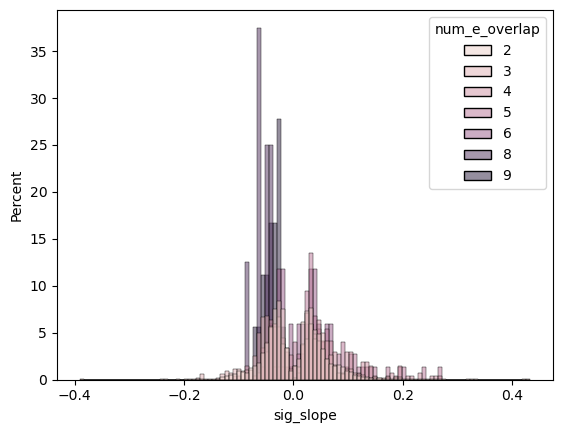

In [13]:
# plot the distribution of the fraction of average, colored by how many sig egenes the var has
sns.histplot(data = multiegene_cs_grouped.explode('sig_slope'), x='sig_slope', hue='num_e_overlap', common_norm=False, stat='percent')

In [18]:
gid_gencode, full_gencode = load_gencode()
multiegene_cs_grouped['lead_var_position'] = var_pos(multiegene_cs_grouped, column='lead_variant_id')

for idx, row in multiegene_cs_grouped.iterrows():
    sig_egenes = [e_var_phenotype.split('_e_')[1] for e_var_phenotype in ast.literal_eval(row['e_overlap'])]
    sig_egenes = pd.Series(sig_egenes).unique()
    sig_tss_starts = gid_gencode.loc[sig_egenes]['tss_start']
    multiegene_cs_grouped.loc[idx, 'num_sig_egenes'] = len(sig_egenes) # might be different from num_e_overlap if one egene has multiple cs
    multiegene_cs_grouped.loc[idx, 'sig_tss_starts']  = str(list(sig_tss_starts))
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance']  = str(list(row['lead_var_position'] - sig_tss_starts))
    abs_distances = abs(sig_tss_starts - row['lead_var_position'])
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance_abs']  = str(list(abs_distances))
    multiegene_cs_grouped.loc[idx, 'sig_tss_var_distance_diff']  = str(list(abs_distances - np.average(abs_distances)))
    multiegene_cs_grouped.loc[idx, 'sig_egenes'] = str(list(sig_egenes))
    


multiegene_cs_grouped['sig_tss_var_distance'] = multiegene_cs_grouped['sig_tss_var_distance'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_tss_var_distance_abs'] = multiegene_cs_grouped['sig_tss_var_distance_abs'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_tss_var_distance_diff'] = multiegene_cs_grouped['sig_tss_var_distance_diff'].apply(ast.literal_eval)
multiegene_cs_grouped['sig_egenes'] = multiegene_cs_grouped['sig_egenes'].apply(ast.literal_eval)

# drop those with multiple cs for the same egene 
multiegene_cs_grouped = multiegene_cs_grouped[multiegene_cs_grouped['num_sig_egenes'] > 1]
len(multiegene_cs_grouped)

3694

## pairs

In [19]:
# to start, look only at pairs as this is a bit easier to understand
pairegene_cs_grouped = multiegene_cs_grouped[multiegene_cs_grouped['num_sig_egenes'] == 2]
pairegene_cs_grouped = pairegene_cs_grouped[pairegene_cs_grouped['N_genes']==2]

<AxesSubplot: xlabel='frac_slope', ylabel='Count'>

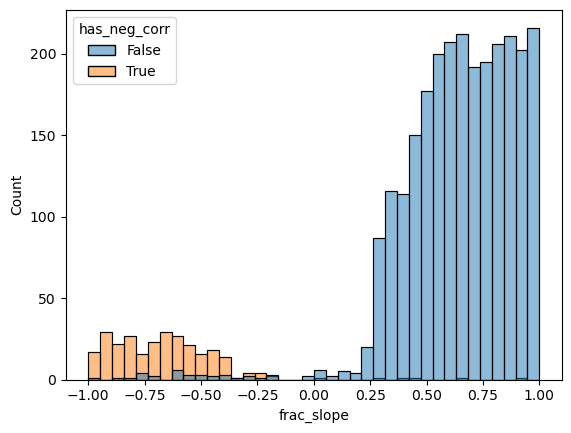

In [32]:
# dependent variable is fraction of slope
pairegene_cs_grouped['frac_slope'] = np.where(abs(pairegene_cs_grouped['sig_slope'].str[0]) > abs(pairegene_cs_grouped['sig_slope'].str[1]), pairegene_cs_grouped['sig_slope'].str[1]/pairegene_cs_grouped['sig_slope'].str[0], pairegene_cs_grouped['sig_slope'].str[0]/pairegene_cs_grouped['sig_slope'].str[1])
sns.histplot(pairegene_cs_grouped, x='frac_slope', hue='has_neg_corr')

In [21]:
pairegene_cs_grouped['lead_var_position'] = pairegene_cs_grouped['lead_variant_id'].str.split('_').str[1].astype(int)
pairegene_cs_grouped['in_bidirectional_promoter'] = ((abs(pairegene_cs_grouped['lead_var_position'] - pairegene_cs_grouped['tss_min']) < 1000) | (abs(pairegene_cs_grouped['lead_var_position'] - pairegene_cs_grouped['tss_max']) < 1000)) & pairegene_cs_grouped['has_bidirectional_promoter']

<AxesSubplot: xlabel='slope_gene_a', ylabel='slope_gene_b'>

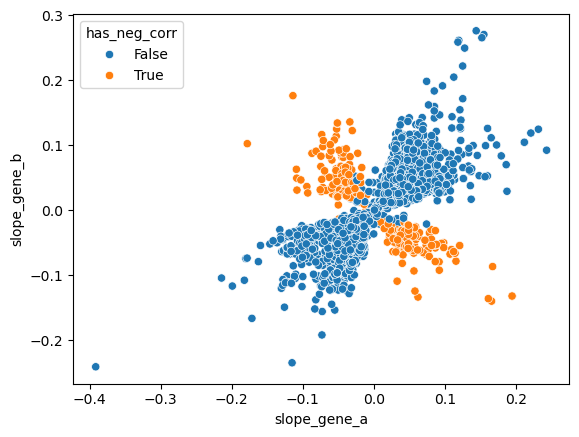

In [22]:
# indep variable is slope for A or B (i.e. mayber larger effect sizes more likely to be shared)
pairegene_cs_grouped['slope_gene_a'] = pairegene_cs_grouped['sig_slope'].str[0]
pairegene_cs_grouped['slope_gene_b'] = pairegene_cs_grouped['sig_slope'].str[1]
sns.scatterplot(pairegene_cs_grouped, x='slope_gene_a', y='slope_gene_b', hue='has_neg_corr')

/local/scratch/klawren/slrmtmp.46699722/ipykernel_28104/3763611146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_clusters['slope_gene_a'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[0]
/local/scratch/klawren/slrmtmp.46699722/ipykernel_28104/3763611146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_clusters['slope_gene_b'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[1]


<AxesSubplot: xlabel='slope_gene_a', ylabel='slope_gene_b'>

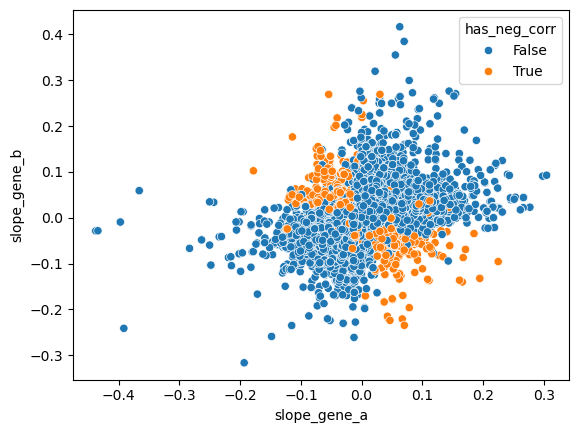

In [41]:
# expand this to all 2 gene clusters, not just ones with multigene qtls
pair_clusters = annot_cs_grouped_pc_susie[annot_cs_grouped_pc_susie['N_genes']==2]
pair_clusters['slope_gene_a'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[0]
pair_clusters['slope_gene_b'] = pair_clusters['e_slope'].apply(ast.literal_eval).str[1]
sns.scatterplot(pair_clusters, x='slope_gene_a', y='slope_gene_b', hue='has_neg_corr')

/local/scratch/klawren/slrmtmp.46699722/ipykernel_28104/1366533527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_clusters['frac_slope'] = np.where(abs(pair_clusters['slope_gene_a']) > abs(pair_clusters['slope_gene_b']), pair_clusters['slope_gene_b']/pair_clusters['slope_gene_a'], pair_clusters['slope_gene_a']/pair_clusters['slope_gene_b'])


<AxesSubplot: xlabel='frac_slope', ylabel='Count'>

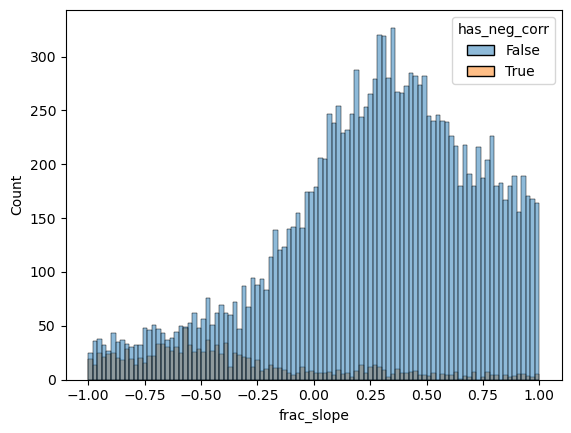

In [42]:
pair_clusters['frac_slope'] = np.where(abs(pair_clusters['slope_gene_a']) > abs(pair_clusters['slope_gene_b']), pair_clusters['slope_gene_b']/pair_clusters['slope_gene_a'], pair_clusters['slope_gene_a']/pair_clusters['slope_gene_b'])
sns.histplot(pair_clusters, x='frac_slope', hue='has_neg_corr', bins=100)

In [52]:
# anything biologically interesting about the neg corr opposite effect ones?
pairegene_cs_grouped['neg_frac_slope'] = pairegene_cs_grouped['frac_slope'] < 0

I want to look at the fraction of average var vs the qtl-tss distance. I hypothesize the closer a qtl is to a gene, the larger the frac var will be. 

Should I include all vars in this? not just the signifigant ones??

### distance

<AxesSubplot: xlabel='sig_tss_var_distance_abs', ylabel='abs_sig_slope'>

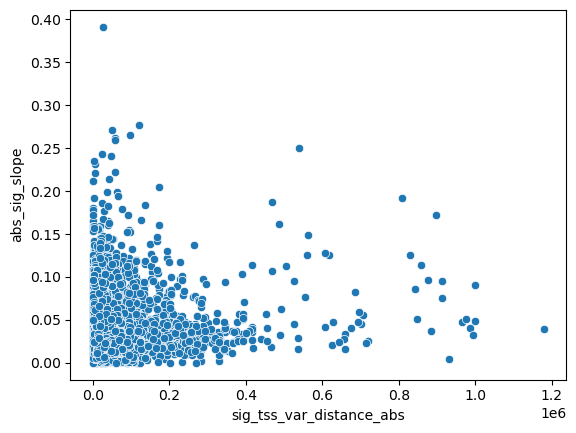

In [72]:
sns.scatterplot(pairegene_cs_grouped.explode(['sig_tss_var_distance_abs', 'abs_sig_slope']), x='sig_tss_var_distance_abs', y='abs_sig_slope')

In [66]:
pairegene_cs_grouped['dist_egene_a'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[0]
pairegene_cs_grouped['dist_egene_b'] = pairegene_cs_grouped['sig_tss_var_distance_abs'].str[1]
pairegene_cs_grouped['dist_frac'] = np.where(abs(pairegene_cs_grouped['slope_gene_a']) > abs(pairegene_cs_grouped['slope_gene_b']), 
                                             pairegene_cs_grouped['dist_egene_b']/pairegene_cs_grouped['dist_egene_a'], 
                                             pairegene_cs_grouped['dist_egene_a']/pairegene_cs_grouped['dist_egene_b'])

pairegene_cs_grouped['log_dist_frac'] = np.where(abs(pairegene_cs_grouped['slope_gene_a']) > abs(pairegene_cs_grouped['slope_gene_b']), 
                                                 np.log10(pairegene_cs_grouped['dist_egene_b']+1) - np.log10(pairegene_cs_grouped['dist_egene_a']+1), 
                                                 np.log10(pairegene_cs_grouped['dist_egene_a']+1) - np.log10(pairegene_cs_grouped['dist_egene_b']+1))

<AxesSubplot: xlabel='log_dist_frac', ylabel='Percent'>

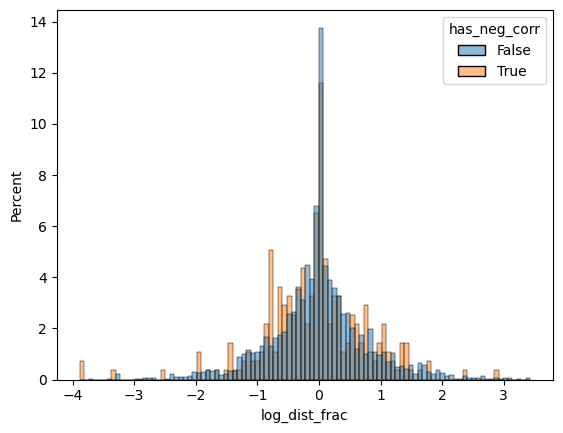

In [67]:
sns.histplot(pairegene_cs_grouped, x='log_dist_frac', hue='has_neg_corr', bins=100, common_norm=False, stat='percent')

In [74]:
pairegene_cs_grouped['dist_frac'].min()

8.667013347200555e-05

(-5.0, 5.0)

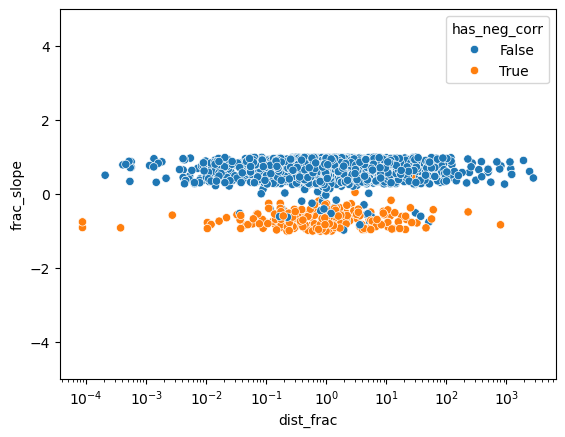

In [73]:
sns.scatterplot(pairegene_cs_grouped, x='dist_frac', y='frac_slope', hue='has_neg_corr')
plt.xscale('log')
plt.ylim(-5, 5)

In [ ]:
sns.scatterplot(pairegene_cs_grouped, x='log_dist_frac', y='frac_slope', hue='has_neg_corr')


#### average expression

In [57]:
average_expression = pd.read_csv(f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv', sep='\t', index_col=0)

<AxesSubplot: xlabel='log_expression_gene_b', ylabel='slope_gene_b'>

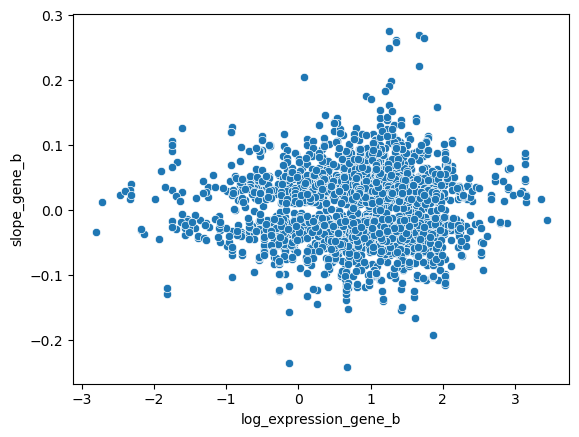

In [63]:
pairegene_cs_grouped['sig_egene_a'] = pairegene_cs_grouped['sig_egenes'].str[0]
pairegene_cs_grouped['sig_egene_b'] = pairegene_cs_grouped['sig_egenes'].str[1]

pairegene_cs_grouped['log_expression_gene_a'] = np.log10(average_expression.loc[my_tissue_id].loc[pairegene_cs_grouped['sig_egene_a']].values)
pairegene_cs_grouped['log_expression_gene_b'] = np.log10(average_expression.loc[my_tissue_id].loc[pairegene_cs_grouped['sig_egene_b']].values)

sns.scatterplot(pairegene_cs_grouped, x='log_expression_gene_b', y='slope_gene_b')

<AxesSubplot: xlabel='log_expression_gene_a', ylabel='log_expression_gene_b'>

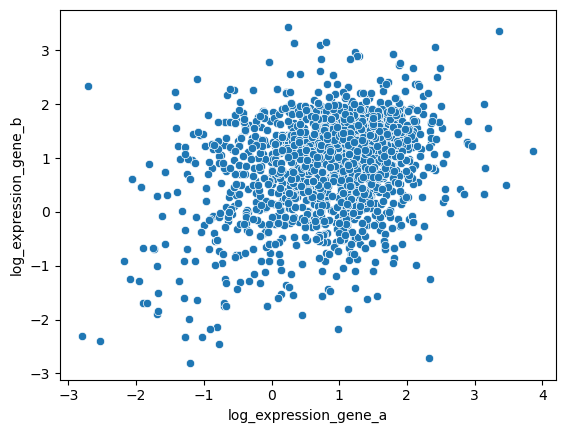

In [62]:
sns.scatterplot(pairegene_cs_grouped, x='log_expression_gene_a', y='log_expression_gene_b')

(-5.0, 5.0)

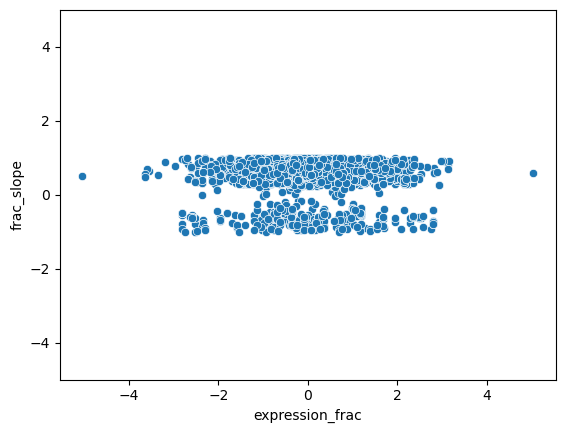

In [65]:
pairegene_cs_grouped['expression_frac'] = np.where(abs(pairegene_cs_grouped['slope_gene_a']) > abs(pairegene_cs_grouped['slope_gene_b']), 
                                                 pairegene_cs_grouped['log_expression_gene_b'] - pairegene_cs_grouped['log_expression_gene_a'], 
                                                 pairegene_cs_grouped['log_expression_gene_a'] - pairegene_cs_grouped['log_expression_gene_b'])
sns.scatterplot(pairegene_cs_grouped, x='expression_frac', y='frac_slope')
plt.ylim(-5, 5)

in ctcfs??

## abc connection

In [248]:
gene_enhancer_df = load_abc(my_tissue_id)
gene_enhancer_df

,gene_name,TargetGene,enhancer,class,ABC.Score
transcript_id,,,,,
ENSG00000187634.11,SAMD11,SAMD11,intergenic|chr1:839603-841066,intergenic,0.022024
ENSG00000187634.11,SAMD11,SAMD11,intergenic|chr1:858775-859990,intergenic,0.038341
ENSG00000187634.11,SAMD11,SAMD11,promoter|chr1:859998-860794,promoter,0.110157
ENSG00000187634.11,SAMD11,SAMD11,genic|chr1:873422-874506,genic,0.019998
ENSG00000187634.11,SAMD11,SAMD11,genic|chr1:875493-876581,genic,0.027442
...,...,...,...,...,...
ENSG00000168939.11_PAR_Y,SPRY3,SPRY3,genic|chrX:153596915-153598726,genic,0.022562
ENSG00000168939.11_PAR_Y,SPRY3,SPRY3,promoter|chrX:154995885-154998520,promoter,0.315121
ENSG00000124333.15_PAR_Y,VAMP7,VAMP7,genic|chrX:153596915-153598726,genic,0.019883
